The strategy we will explore in this chapter comes from the book THE 12% SOLUTION by David Allan Carter.

Here we will only explore the solution, which should return 12% on average over 10 years.

There is a 60-40 percent assets-hedge split.

The hedge is kept in TLT and the assets in one of the following SPY, IWM, MDY, QQQ, or cash.

This is a monthly strategy. We only make changes on a monthly basis and based on a 3-month lookback. Hence, we only need monthly data for our backtesting.

In [1]:
import pandas_datareader as pdr
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tickers = ['SPY','IWM','MDY','QQQ','TLT']
start = dt.datetime(2007,1,1)
end = dt.datetime(2021,1,1)
data = pdr.get_data_yahoo(tickers,start,end,interval = 'm')
data = data['Adj Close']

In [5]:
data.tail()

Symbols,SPY,IWM,MDY,QQQ,Short,TLT
Date,,,,,,
2020-09-01,326.754822,147.359680,333.359344,275.666809,1.0,159.496613
2020-10-01,319.883026,151.180176,341.703217,267.272949,1.0,154.111649
2020-11-01,354.678833,178.761749,390.560272,297.276459,1.0,156.670059
2020-12-01,366.257874,193.614120,414.381927,311.286041,1.0,154.593811
2021-01-01,364.070923,203.629059,421.797546,312.665283,1.0,149.285217


When we create our strategy, we should also have the option to hold cash. This can be modeled by adding a column with no growth.

In [4]:
data['Short'] = 1.0
data = data[['SPY','IWM','MDY','QQQ','Short','TLT']]


In [6]:
log_returns = np.log(data/data.shift())

Now we need to find the return of the 12% solution.
We need to figure out which assets retuned the most in the last 3 months

In [8]:
strat = log_returns[['SPY','IWM','MDY','QQQ','Short']].copy()
rolling_sum = strat.copy()

for ticker in ['SPY','IWM','MDY','QQQ','Short']:
    rolling_sum[ticker] = rolling_sum[ticker].rolling(3).sum()

We simply calculate the rolling sum over the last 3 months for all of them. Notice, we have excluded TLT from our calculations, as it will only have a 40% holding and not change.

In [11]:
rtn = strat[rolling_sum.apply(lambda x: x== rolling_sum.max(axis=1)).shift()].sum(axis=1)*.6
rtn = rtn + log_returns['TLT']*.4

In [12]:
rtn

Date
2007-01-01         NaN
2007-02-01    0.011706
2007-03-01   -0.006759
2007-04-01    0.003648
2007-05-01    0.020673
                ...   
2020-09-01   -0.032639
2020-10-01   -0.032292
2020-11-01    0.107135
2020-12-01    0.042552
2021-01-01    0.016283
Length: 169, dtype: float64

Project – Backtesting the 12% solution

In [13]:
def calculate(log_returns,start,end):
    years = int(end) - int(start) +1

    data = log_returns.loc[start:end]

    cagr = np.exp(data.sum())**(1/years) - 1

    norm = data.cumsum().apply(np.exp)

    rolling_max = norm.cummax()
    monthly_drawdown = norm/rolling_max - 1
    drawdown = monthly_drawdown.cummin().iloc[-1]

    volatality = data.std()*(12**.5)

    return cagr,drawdown,volatality

In [14]:
def visualize(backtest, spy, start, end):
    def x_titles(spy_val, bt_val):
        spy_str = str(round(spy_val*100,1))
        bt_str = str(round(bt_val*100,1))
        return ['SPY\n' + spy_str + '%', 'Backtest\n'+ bt_str + '%']

    spy_cagr,spy_drawdown,spy_vol = calculate(spy,start,end)
    bt_cagr, bt_drawdown, bt_vol = calculate(backtest, start, end)

    fig,ax = plt.subplots(2,2)

    spy.loc[start:end].cumsum().apply(np.exp).plot(ax=ax[0 ,0]) 
    backtest.loc[start:end].cumsum().apply(np.exp).plot(ax=ax[0,0], label = 'Backtest', c='c')
    ax[0,0].legend()

    x = x_titles(spy_cagr,bt_cagr)
    ax[0,1].bar(x,[spy_cagr,bt_cagr],color=['b','c'])
    ax[0,1].set_title('CAGR')

    x = x_titles(spy_drawdown,bt_drawdown)
    ax[1,0].bar(x,[spy_drawdown,bt_drawdown],color=['b','c'])
    ax[1,0].set_title('Drawdown')

    x = x_titles(spy_vol,bt_vol)
    ax[1,1].bar(x,[spy_vol,bt_vol],color=['b','c'])
    ax[1,1].set_title('Volatality')

    plt.tight_layout()


Let’s do some backtesting. First for the period 2008 and 10 years forward.

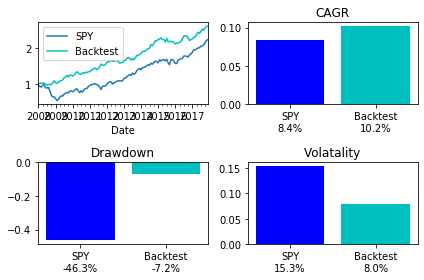

In [15]:
visualize(rtn, log_returns['SPY'],'2008','2017')

A return of 10.2%, a low maximum drawdown (7.2%) and low volatility (8.0%).

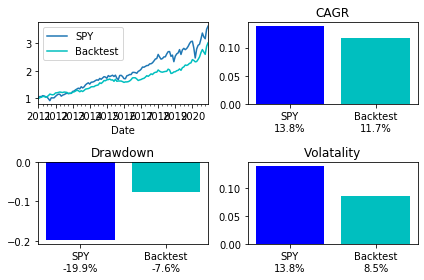

In [16]:
visualize(rtn, log_returns['SPY'],'2011','2020')

A return of 11.7%, though during this 10-year period the SPY returned 13.8% (calculated on a monthly basis). Low drawdown and volatility